# [SF-DST] Credit Scoring

## Прогнозирование вероятности дефолта заемщика

### Работа Калашникова Сергея


### Загрузка данных


Информация из анкетных данных заемщиков и факт наличия дефолта.

Задача: спрогнозировать вероятность дефолта для новых клиентов.

Описания полей:

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

### 0. Билиотеки, функции, классы

In [1]:
from pandas import Series
import pandas as pd
import numpy as np

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from datetime import datetime, timedelta

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

import warnings
warnings.filterwarnings("ignore")


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [2]:
# Функция построения графика ROC AUC
def show_roc_auc(y_test, y_probs): 
    fpr, tpr, threshold = roc_curve(y_test, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

# Функция построения матрицы ошибок
def show_confusion_matrix(lastmodel,X_test,y_test):    
    class_names = ['NonDefault', 'Default']
    titles_options = [("Confusion matrix", None)]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(lastmodel, X_test, y_test, 
                                     display_labels=class_names, 
                                     cmap=plt.cm.Blues, 
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()
    
# Функция визуализации данных числовых признаков
def num_column_analysis(i):
    display(pd.DataFrame(train[i].value_counts(normalize=True, sort=True)))
    sns.boxplot(x = 'default', y = i, data = train) 
    plt.show()
    train[i].hist(bins = 100) 
    
# Функция объединения признаков car и car_typе    
def combining_types_car(row):
    result = row['car'] + row['car_type'] 
    return result

# Функция объединения признаков home_address и work_address
def combining_types_adr(row):
    result = 10*row['home_address'] + row['work_address'] 
    return result


# 1. Загрузка и предварительный осмотр данных

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

Размер тренировочного и тестового датасетов.

In [4]:
print('Размер тренировочного датасета: ', train.shape,
      'Размер тестового датасета: ', test.shape, 
      'Размер объединенного датасета: ', train.shape[0]+test.shape[0], sep='\n')

Размер тренировочного датасета: 
(73799, 19)
Размер тестового датасета: 
(36349, 18)
Размер объединенного датасета: 
110148


Объединяем тренировочные и тестовые данные в один датасет для того чтоб все монипуляции с признаками проводить на обоих датасетах

In [5]:
train['train'] = 1 # тренировочные
test['train'] = 0 # тестовые
df = pd.concat([train, test], ignore_index=True)
df.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
93166,19823,27JAN2014,SCH,M,49,Y,Y,0,0,-2.177729,4,70,1,2,70000,1,3,N,NaN,0
12063,5298,12JAN2014,SCH,M,21,N,N,0,0,-1.557774,1,40,2,3,20000,4,1,N,0.0,1
40149,29421,05FEB2014,GRD,M,25,N,N,0,0,-2.024100,2,80,2,3,40000,1,3,N,0.0,1
40304,24225,31JAN2014,GRD,F,42,Y,Y,0,1,-2.493746,0,80,2,3,115000,1,3,Y,0.0,1
11627,87929,04APR2014,SCH,F,30,N,N,0,1,-0.968535,1,50,1,1,15000,2,3,N,1.0,1


# Общая информация о полях

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [7]:
df.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,train
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,73799.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.126994,0.669999
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.332968,0.470215
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,1.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


EDA c помощью pandas_profiling

In [8]:
# pandas_profiling.ProfileReport(df)

Пропуски в колонке education.  
Выборка не сбалансирована.   
Количество дефолтных клиентов в 6 раз больше чем не дефолтных.   
Коррелируют между собой признаки: first_time/sna, work_address/home_address.  

# 2. Предварительная обработка данных для построения первой модели

### 2.1    
Избавимся от пропусков в колонке education.
Меняем пропуски на случайными значениями, в том же соотношении (Используем только - SCH, GRD, UGR)

In [9]:
df['education'].value_counts(normalize=True)

SCH    0.528841
GRD    0.317024
UGR    0.134476
PGR    0.017006
ACD    0.002653
Name: education, dtype: float64

In [10]:
df.fillna('empty',inplace=True)
df['education']=df['education'].apply(lambda x: np.random.choice(['SCH','GRD','UGR'],p=[0.53,0.33,0.14]) 
                                     if x=='empty' else x)

### 2.2    
Переводим дату в подходящий вид.   
Формируем новые признаки на основе даты.  

In [11]:
df['app_date'] = pd.to_datetime(df['app_date'])
df['day'] = df.app_date.dt.day
df['month'] = df.app_date.dt.month
df['weekday'] = df.app_date.dt.weekday
df['days'] = (df.app_date.max() - df.app_date).dt.days # Кол-во дней до даты конца наблюдений
df.drop(['app_date'],axis=1, inplace=True) # Убираем app_date

### 2.3  
Создаем списки числовых, бинарных и категориальных переменных:

In [12]:
# числовые
num_cols = [
    'age',
    'decline_app_cnt',
    'score_bki',
    'bki_request_cnt',
    'income',
    'day',
    'month',
    'weekday',
    'days'
    ]

# бинарные, сразу используем LabelEncoder
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"]

label_encoder = LabelEncoder()

for i in bin_cols:
    df[i] = label_encoder.fit_transform(df[i])

# категориальные
cat_cols = [
    'education',
    'region_rating',
    'home_address',
    'work_address',
    'sna',
    'first_time',
    ]         

### 2.4 
Разделим датасет на обучающую и тестовую часть.  
Проведем OneHot-кодирование категориальных признаков.  
Объединяем числовые, бинарные и категориальные переменные в одно признаковое пространство.  

In [13]:
train = df[df['train']==1].drop(['train'],axis=1)
test = df[df['train']==0].drop(['train','default'],axis=1)

X_cat = OneHotEncoder(sparse=False).fit_transform(train[cat_cols].values)

X = np.hstack([train[num_cols], train[bin_cols].values,X_cat])
Y = train['default'].to_numpy().astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=32)

# 3. Построим предворительная модель

Обучаем модель.  
Строим ROC AUC.  
Строим матрицу ошибок.  
Выводим метрики.  

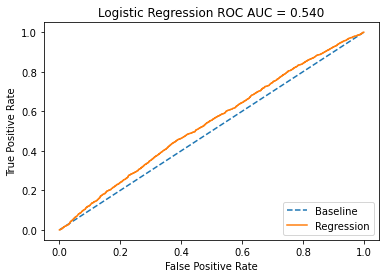

Confusion matrix
[[12855     0]
 [ 1905     0]]


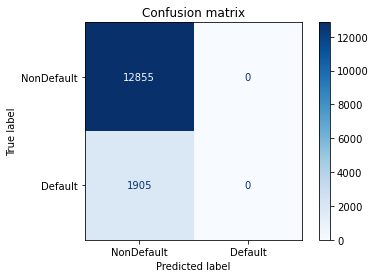

accuracy_score: 0.8709
f1_score: 0.0
recall_score: 0.0


In [14]:
model_0 = LogisticRegression(solver='liblinear')
model_0.fit(X_train, y_train)
y_pred = model_0.predict(X_test)

probs = model_0.predict_proba(X_test)
probs = probs[:,1]
show_roc_auc(y_test,probs)

show_confusion_matrix(model_0,X_test,y_test)

print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))

print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))

print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))

Значение ROC AUC 0.54.   
Модель вообще не предсказала дефолтных клиетов.

# 4. Доп. обработка данных

### 4.1 Корреляция числовых признаков между собой и их значимость.

<AxesSubplot:>

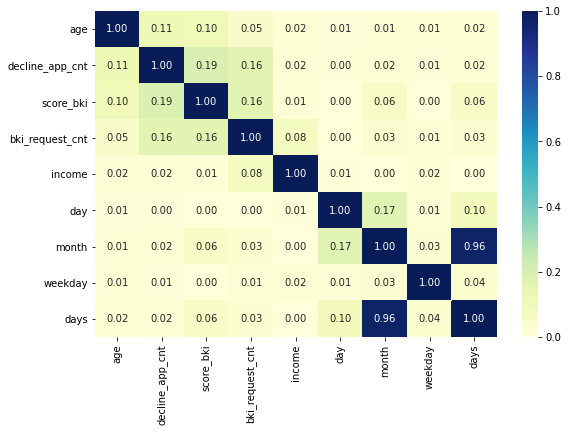

In [15]:
plt.figure(figsize=(9, 6))
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1,
            annot=True, fmt=".2f", cmap="YlGnBu")

<AxesSubplot:>

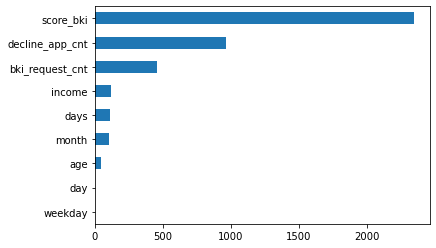

In [16]:
temp = df[df['train'] == 1]
imp_num = pd.Series(f_classif(temp[num_cols], temp['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Коррелируют days/month.  
Убираем month, day и weekday - не оказывают значимого влияния на целевую переменную.

In [17]:
df.drop(['month','day','weekday'],axis=1,inplace=True)
num_cols.remove('month')
num_cols.remove('day')
num_cols.remove('weekday')

### 4.2 Корреляция биномаильных признаков.

<AxesSubplot:>

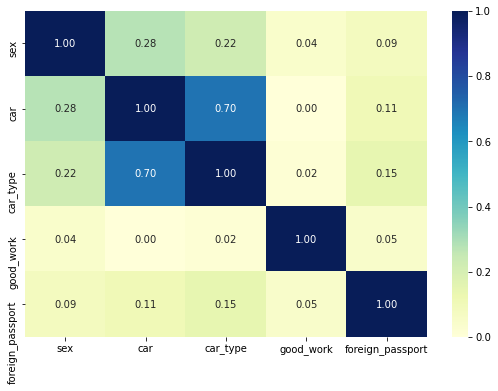

In [18]:
plt.figure(figsize=(9, 6))
sns.heatmap(df[bin_cols].corr().abs(), vmin=0, vmax=1,
            annot=True, fmt=".2f", cmap="YlGnBu")

Корреляция признаков car и car_type. объединим в один.

In [19]:
df['car'] = df.apply(lambda row: combining_types_car(row), axis=1)
df.drop(['car_type'],axis=1,inplace=True)
bin_cols.remove('car_type')

### 4.3 Корреляция категориальных признаков.

<AxesSubplot:>

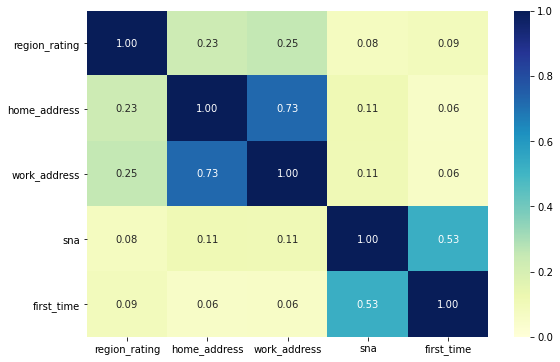

In [20]:
plt.figure(figsize=(9, 6))
sns.heatmap(df[cat_cols].corr().abs(), vmin=0, vmax=1,
            annot=True, fmt=".2f", cmap="YlGnBu")

Корреляция между пизнаками work_address/home_address и sna/first_time.  
Объеденим адрес.

In [21]:
df['address'] = df.apply(lambda row: combining_types_adr(row), axis=1)

cat_cols.append('address')

cat_cols.remove('home_address')
df.drop(['home_address'], axis=1, inplace=True)

cat_cols.remove('work_address')
df.drop(['work_address'], axis=1, inplace=True)

Разделим категориальные признаки по столбцам

In [22]:
df = pd.get_dummies(
    df, columns=['education', 'region_rating', 'sna', 'first_time', 'address','sex', 'car', 'good_work', 'foreign_passport'], dummy_na=False)

### 4.4 Числовые признаки

In [23]:
train = df[df['train']==1].drop(['train'],axis=1)
test = df[df['train']==0].drop(['train','default'],axis=1)

#### 4.4.1 Стоблец Аge

,age
31,0.036952
28,0.036654
30,0.036491
29,0.036030
27,0.035841
...,...
68,0.002236
69,0.001098
70,0.000434
71,0.000041


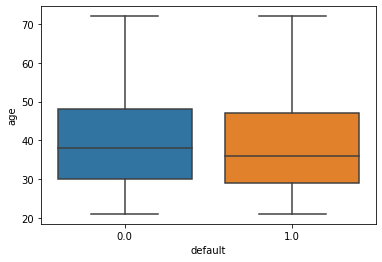

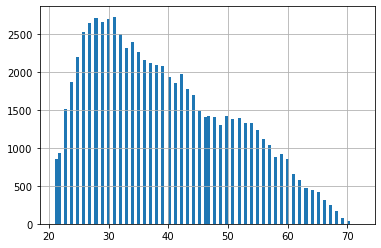

In [24]:

num_column_analysis('age')

Выбросов нет.
Распределение значений смещено в право. 
Прологарифмируем этот признак.

In [25]:
train['age'] = np.log(train['age'] + 1)
test['age'] = np.log(test['age'] + 1)

#### 4.4.1 Стоблец decline_app_cnt

,decline_app_cnt
0,0.829469
1,0.113782
2,0.033442
3,0.012236
4,0.005610
5,0.002236
6,0.001531
7,0.000650
9,0.000325
8,0.000257


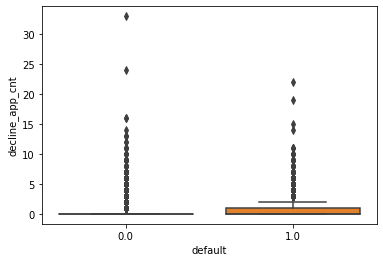

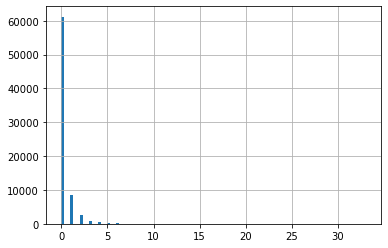

In [26]:
num_column_analysis('decline_app_cnt')

Есть выбросы.  
Это значения больше 4, их сумма меньше 1%. Заменим их нам на 4.

In [27]:
train['decline_app_cnt']=train['decline_app_cnt'].apply(lambda x: x if x<=4 else 4)

#### 4.4.2 Cтолбец score_bki

,score_bki
-1.775263,0.004770
-2.225004,0.004011
-2.104211,0.003902
-2.169664,0.003496
-1.920823,0.002507
...,...
-1.243395,0.000014
-1.732555,0.000014
-1.904082,0.000014
-2.386521,0.000014


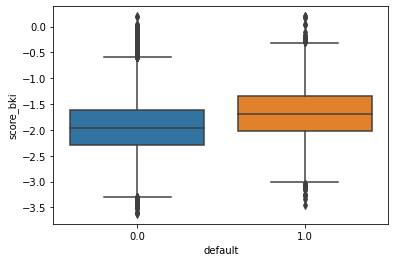

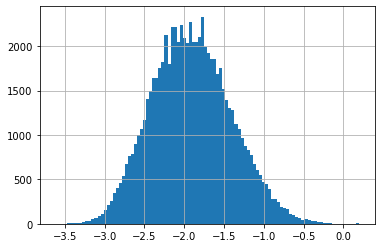

In [28]:
num_column_analysis('score_bki')

Распределение нормальное. Выбросы хоть и есть, но их пока можно оставить.

#### 4.4.3 Столбец bki_request_cnt

,bki_request_cnt
0,0.262619
1,0.247646
2,0.186303
3,0.124487
4,0.076248
5,0.044282
6,0.023090
7,0.011545
8,0.006884
9,0.004052


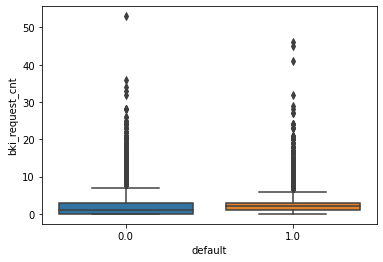

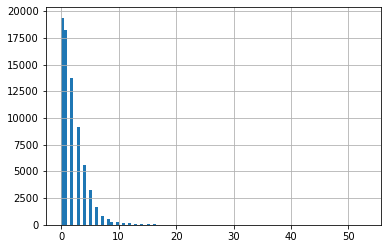

In [29]:
num_column_analysis('bki_request_cnt')

Есть выбросы. Сумма значений выше 9 очень, меньше 1%. Все что больше 9 заменим на 9. Дополнительно прологарифмируем признак.

In [30]:
train['bki_request_cnt']=train['bki_request_cnt'].apply(lambda x: x if x<=9 else 9)

In [31]:
train['bki_request_cnt'] = np.log(train['bki_request_cnt'] + 1)
test['bki_request_cnt'] = np.log(test['bki_request_cnt'] + 1)

#### 4.4.4 Столбец income

,income
30000,0.094974
25000,0.082128
20000,0.074134
40000,0.066871
50000,0.060570
...,...
37600,0.000014
27350,0.000014
27478,0.000014
53800,0.000014


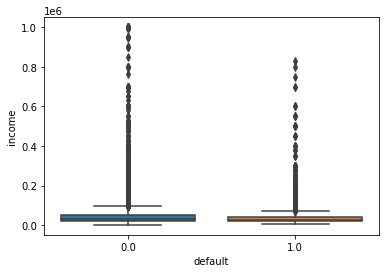

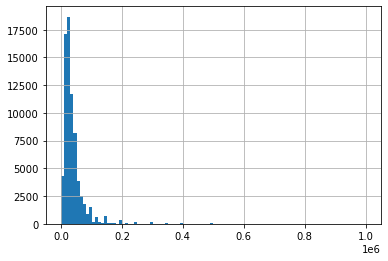

In [32]:
num_column_analysis('income')

Здесь тоже наблюдаем много выбросов. Больше 200к получают малое количество клиентов. Приравняем их доход к 200к. Также прологорифмируем этот признак чтоб привести его к более нормальному распределению.

Тут тоже наблюдаем выбросы. Т.к. их суммарная доля после значения 9 очень мала (меньше 1%), то все что больше 9 заменим на 9. Распределение здесь смещено в право, прологарифмируем этот признак.

In [33]:
train['income']=train['income'].apply(lambda x: x if x<=200000 else 200000)

In [34]:
train['income']=train['income'].apply(lambda x: x if x<=200000 else 200000)

In [35]:
train['income'] = np.log(train['income'] + 1)
test['income'] = np.log(test['income'] + 1)

# 5. Построение модели

Стандартизируем числовые признаки в обучающей и тестовой выборке.
Обновим общий датасет и разделим выборку на обучающую и тестовую.

In [36]:
scaler=StandardScaler().fit(train[num_cols])
train_std=scaler.transform(train[num_cols])
train[num_cols]=train_std
test_std=scaler.transform(test[num_cols])
test[num_cols]=test_std

train['train'] = 1 # тренировочные
test['train'] = 0 # тестовые
df = pd.concat([train, test], ignore_index=True)

X = train[list(set(train.columns) - set(['default','client_id']))].values
Y = train['default'].to_numpy().astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=32)

Обучаем модель.
Строим ROC AUC.
Строим матрицу ошибок.
Выводим метрики.

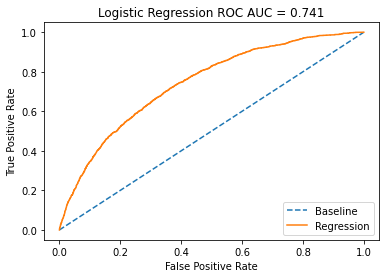

Confusion matrix
[[12793    62]
 [ 1848    57]]


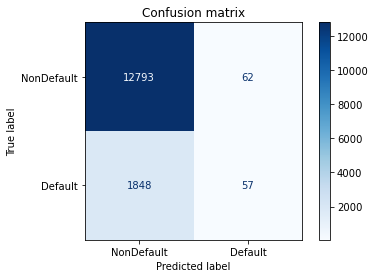

accuracy_score: 0.8706
f1_score: 0.0563
recall_score: 0.0299


In [37]:
model_1 = LogisticRegression(solver='liblinear')
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)

probs = model_1.predict_proba(X_test)
probs = probs[:,1]
show_roc_auc(y_test,probs)

show_confusion_matrix(model_1,X_test,y_test)

print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))

ROC AUC = 0.741.    
Модель начала определять дефолтных клиентов. 

# 6. Модель + полиноминальные признаки и гиперпараметры

In [38]:
# добавим новые признаки, через комбинацию
data=df.copy()
poly = PolynomialFeatures(2, include_bias=False)
poly_data = poly.fit_transform(data[num_cols])[:, len(num_cols):]
poly_cols = poly.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
data = data.join(poly_df,  how='left')

C = np.logspace(0, 4, 10)

penalty = ['l1','l2']
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(solver = 'liblinear')
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

# Разделяем датасет
train_p = data[data['train']==1].drop(['train'],axis=1)
test_p = data[data['train']==0].drop(['train','default'],axis=1)

X = train_p[list(set(train_p.columns) - set(['default','client_id']))].values
Y = train_p['default'].to_numpy().astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=32)


Лучший penalty: l1
Лучшее C: 1.0


Обучаем модель. Строим ROC AUC. Строим матрицу ошибок. Выводим метрики.

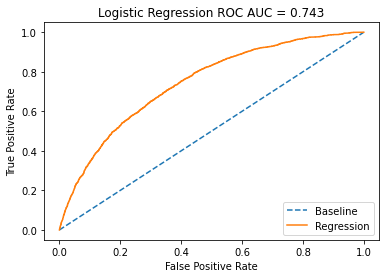

Confusion matrix
[[12791    64]
 [ 1849    56]]


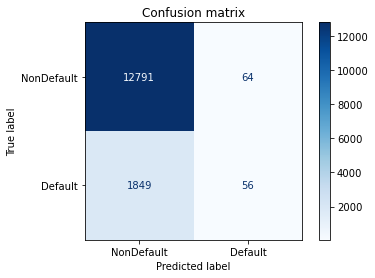

accuracy_score: 0.8704
f1_score: 0.0553
recall_score: 0.0294


In [39]:
model_finish = LogisticRegression(penalty='l1', C=1.0, solver='liblinear')
model_finish.fit(X_train, y_train)
y_pred = model_finish.predict(X_test)

probs = model_finish.predict_proba(X_test)
probs = probs[:,1]
show_roc_auc(y_test,probs)

show_confusion_matrix(model_finish,X_test,y_test)

print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))

Результат немного улучшился. Модель предсказывает большое количество ложно - не дефолтных клиентов.

# 7. Подготовка данных для kaggle

In [40]:
X_test_fin = test_p[list(set(test_p.columns) - set(['default','client_id']))].values

y_probs = model_finish.predict_proba(X_test_fin)[:,1]

test_p['default'] = y_probs
submission = test_p[['client_id','default']]
display(submission.sample(10))
display(submission.shape)

submission.to_csv('submission.csv', index=False)

,client_id,default
99454,101829,0.063373
103289,63953,0.369246
76663,106644,0.207716
88994,35679,0.134243
78865,24544,0.080598
77458,21457,0.194336
97326,70178,0.065139
82512,76639,0.090187
101393,38923,0.064735
107793,93661,0.472320


(36349, 2)